# Image Segmentation of Handwriting Digits Prediction
- Dataset: M2NIST (multi digits mnist)
- using CNN, FCN-8 models
- evaluate by IOU, Dice score

## Imports

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds

## Download the dataset

[M2NIST](https://www.kaggle.com/farhanhubble/multimnistm2nist) is a **multi digit** [MNIST](http://yann.lecun.com/exdb/mnist/).
Each image has up to 3 digits from MNIST digits and the corresponding labels file has the segmentation masks.

The dataset is available on [Kaggle](https://www.kaggle.com) and you can find it [here](https://www.kaggle.com/farhanhubble/multimnistm2nist)

To make it easier for you, we're hosting it on Google Cloud so you can download without Kaggle credentials.


In [2]:
# download zipped dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip \
    -O /tmp/m2nist.zip

# find and extract to a local folder ('/tmp/training')
local_zip = '/tmp/m2nist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

--2024-04-09 13:10:40--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
正在解析主机 storage.googleapis.com (storage.googleapis.com)... 142.251.43.27, 172.217.160.123, 172.217.163.59, ...
正在连接 storage.googleapis.com (storage.googleapis.com)|142.251.43.27|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：17378168 (17M) [application/zip]
正在保存至: “/tmp/m2nist.zip”

/tmp/m2nist.zip     100%[===================>]  16.57M  5.65MB/s  用时 2.9s      

2024-04-09 13:10:43 (5.65 MB/s) - 已保存 “/tmp/m2nist.zip” [17378168/17378168])



## Load and process dataset

This dataset can be easily preprocessed since it is available as **Numpy Array Files (.npy)**

1. **combined.npy** has the image files containing the multiple MNIST digits. Each image is of size **64 x 84** (height x width, in pixels).

2. **segmented.npy** has the corresponding segmentation masks. Each segmentation mask is also of size **64 x 84**.

This dataset has **5000** samples and you can make appropriate training, validation, and test splits as required for the problem.

With that, let's define a few utility functions for loading and preprocessing the dataset.

In [5]:
BATCH_SIZE = 32

In [6]:
def read_image_and_annotation(image, annotation):
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image,(image.shape[0], image.shape[1],1,))
    image /= 127.5
    image -= 1
    annotation = tf.cast(annotation, tf.int32)
    return image, annotation

In [8]:
def get_training_dataset(image, annotation):
    train_dataset = tf.data.Dataset.from_tensor_slices((image, annotation))
    train_dataset = train_dataset.map(read_image_and_annotation).shuffle(512, reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.repeat()
    train_dataset = train_dataset.prefetch(-1)
    return train_dataset

In [9]:
def get_validation_dataset(image, annotation):
    val_dataset = tf.data.Dataset.from_tensor_slices((image, annotation))
    val_dataset = val_dataset.map(read_image_and_annotation).batch(BATCH_SIZE, drop_remainder=True)
    return val_dataset

In [10]:
def get_test_dataset(image, annotation):
    test_dataset = tf.data.Dataset.from_tensor_slices((image, annotation))
    test_dataset = test_dataset.map(read_image_and_annotation).batch(BATCH_SIZE, drop_remainder=True)
    return test_dataset

In [13]:
def load_images_and_segments():
    images = np.load("/tmp/training/combined.npy")
    segments = np.load("/tmp/training/segmented.npy")
    train_images, val_images, train_annos, val_annos = train_test_split(images, segments, test_size=0.2, shuffle=True)
    val_images, test_images, val_annos, test_annos = train_test_split(val_images, val_annos, test_size=0.2, shuffle=True)
    return (train_images,train_annos),(val_images, val_annos),(test_images, test_annos)

In [14]:
#load data in pairs
train_ds, val_ds, test_ds = load_images_and_segments()

In [15]:
train_dataset = get_training_dataset(train_ds[0], train_ds[1])
validation_dataset = get_validation_dataset(val_ds[0], val_ds[1])
test_dataset = get_test_dataset(test_ds[0], test_ds[1])

## Visual and inspect dataset

In [16]:
# Visualization Utilities

# there are 11 classes in the dataset: one class for each digit (0 to 9) plus the background class
n_classes = 11

# assign a random color for each class
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(n_classes)]

In [41]:
def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste

  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array

  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(n_classes):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img


def show_annotation_and_prediction(image, annotation, prediction, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps. Also overlays the metrics.

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the ground truth label map
    prediction (numpy array) -- the predicted label map
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each class
  '''

  new_ann = np.argmax(annotation, axis=2)
  true_img = give_color_to_annotation(new_ann)
  pred_img = give_color_to_annotation(prediction)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))
  image = np.uint8(image)
  images = [image, np.uint8(pred_img), np.uint8(true_img)]

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0 and idx < 10]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(idx, iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.reshape(image, (image.shape[0], image.shape[1],))

  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, num_images):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) -- batch of images and annotations
    num_images (int) -- number of images to display
  '''
  ds = dataset.unbatch()

  plt.figure(figsize=(12,4))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(ds.take(num_images)):
    plt.subplot(5, 5, idx + 1)
    plt.yticks([])
    plt.xticks([])
    plt.axis('off')
    show_annotation_and_image(image.numpy(), annotation.numpy())

2024-04-09 13:53:54.060697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


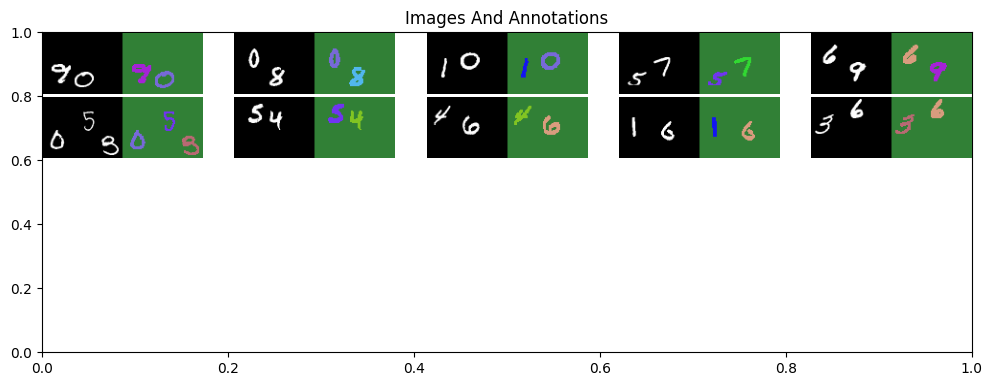

In [42]:
# get 10 images from the training set
list_show_annotation(train_dataset, 10)

2024-04-09 13:54:15.222929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


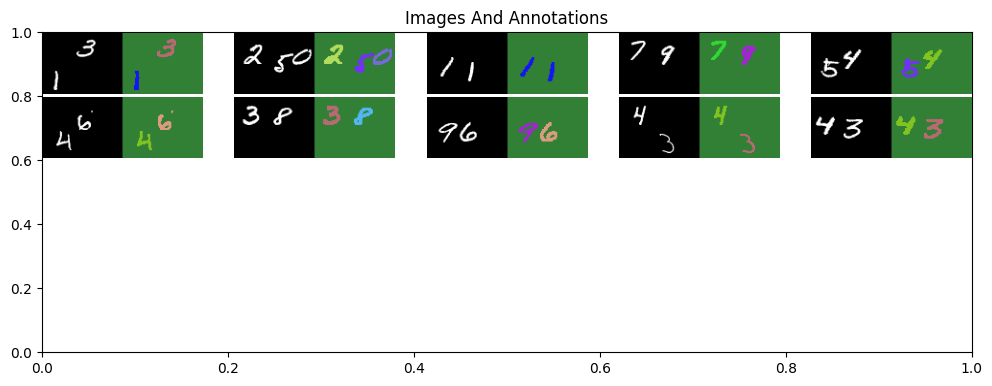

In [43]:
# get 10 images from the validation set
list_show_annotation(validation_dataset, 10)

## Define a custom model 
1. downsampling path - This part of the network extracts the features in the image. This is done through a series of convolution and pooling layers.
2. upsampling path - This takes the output of the downsampling path and generates the predictions while also converting the image back to its original size. You will use an FCN-8 decoder for this path.

In [62]:
# parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'
def conv_block(inputs, filters, kernel_size, pooling_size, pool_strides):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', data_format=IMAGE_ORDERING)(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

In [63]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(64,84, 1))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 84, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 84, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_42 (LeakyReLU)      │ (None, 64, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 64, 84, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_43 (LeakyReLU)      │ (None, 64, 84, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 42, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,696 (37.88 KB)

 Trainable params: 9,632 (37.62 KB)

 Non-trainable params: 64 (256.00 B)

None


### Define the Downsampling Path

In [64]:
def FCN8(input_height=64, input_width=84):
    
    inputs = tf.keras.layers.Input(shape=(input_height, input_width, 1))
    
    # pad the input image width to 96 pixels
    x = tf.keras.layers.ZeroPadding2D(((0,0),(0, 96-input_width)))(inputs)
    #block 1
    x = conv_block(x, 32, 3, 2, 2)
    #block 2
    x = conv_block(x, 64, 3, 2, 2)
    #block 3
    x = conv_block(x, 128, 3, 2, 2)
    # save the feature map at this stage
    f3 = x
    #block 4
    x = conv_block(x, 256, 3, 2, 2)
    # save the feature map at this stage
    f4 = x
    #block 5
    x = conv_block(x, 256, 3, 2, 2)
    # save the feature map at this stage
    f5 = x
    return (f3, f4, f5), inputs

### Define the FCN-8 decoder

In [65]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)


  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = (tf.keras.layers.Conv2D(n_classes, kernel_size=(1,1), activation='relu', padding='same',data_format=IMAGE_ORDERING))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides=(2,2), use_bias=False)(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides=(8,8), use_bias=False)(o)
  o = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  # append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o

In [66]:
# TEST CODE

test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 11)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 84, 11)


### Define the Complete Model

The downsampling and upsampling paths can now be combined as shown below.

In [67]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

In [68]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 64, 84, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 64, 96, 1) │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 96,    │        320 │ zero_padding2d_6… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_54      │ (None, 64, 96,    │          0 │ conv2d_58[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 96,    │      9,248 │ leaky_re_lu_54[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_55      │ (None, 64, 96,    │          0 │ conv2d_59[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 48,    │          0 │ leaky_re_lu_55[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 48,    │        128 │ max_pooling2d_27… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 32, 48,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 32, 48,    │          0 │ conv2d_60[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 48,    │     36,928 │ leaky_re_lu_56[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, 32, 48,    │          0 │ conv2d_61[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 16, 24,    │          0 │ leaky_re_lu_57[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 24,    │        256 │ max_pooling2d_28… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 16, 24,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 16, 24,    │          0 │ conv2d_62[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 24,    │    147,584 │ leaky_re_lu_58[0

 Total params: 2,413,766 (9.21 MB)

 Trainable params: 2,412,294 (9.20 MB)

 Non-trainable params: 1,472 (5.75 KB)

## Compile the Model

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [71]:

EPOCHS = 10

steps_per_epoch = 4000//BATCH_SIZE
validation_steps = 800//BATCH_SIZE
test_steps = 200//BATCH_SIZE


history = model.fit(train_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.7003 - loss: 0.9777 - val_accuracy: 0.9426 - val_loss: 0.5107
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - accuracy: 0.9425 - loss: 0.2093 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 0.9395 - loss: 0.2051

2024-04-09 14:22:21.228128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.9437 - loss: 0.1911 - val_accuracy: 0.9426 - val_loss: 0.3488
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.9486 - loss: 0.1602 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 0.9596 - loss: 0.1158

2024-04-09 14:22:59.355248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.9608 - loss: 0.1113 - val_accuracy: 0.9609 - val_loss: 0.1088
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.9699 - loss: 0.0801 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 0.9750 - loss: 0.0662

2024-04-09 14:23:38.083285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.9742 - loss: 0.0665 - val_accuracy: 0.9711 - val_loss: 0.0780
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.9768 - loss: 0.0589 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/10
  1/125 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 0.9811 - loss: 0.0499

2024-04-09 14:24:17.205401: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - accuracy: 0.9788 - loss: 0.0528 - val_accuracy: 0.9753 - val_loss: 0.0650
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 0.9803 - loss: 0.0490 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


2024-04-09 14:24:56.936701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Model Evaluation

In [72]:
results = model.predict(test_dataset, steps=test_steps)

print(results.shape)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(192, 64, 84, 11)


In [73]:
print(results[0,0,0,0])
print(results[0,0,0,10])

0.009725766
0.9652808


In [74]:
results = np.argmax(results, axis=3)

print(results.shape)

(192, 64, 84)


In [75]:
print(results[0,0,0])

# prediction map for image 0
print(results[0,:,:])

10
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]


### Metrics

We showed in the lectures two ways to evaluate your predictions. The *intersection over union (IOU)* and the *dice score*. Recall that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

The code below does that for you as you've also seen in the ungraded lab. A small smoothing factor is introduced in the denominators to prevent possible division by zero.

In [76]:
def class_wise_metrics(y_true, y_pred):
  '''
  Computes the class-wise IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label maps
    y_pred (tensor) - predicted label maps
  '''
  class_wise_iou = []
  class_wise_dice_score = []

  smoothing_factor = 0.00001

  for i in range(n_classes):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection) / (combined_area - intersection + smoothing_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection) / (combined_area + smoothing_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score


### Visualize Predictions

2024-04-09 14:29:55.957543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


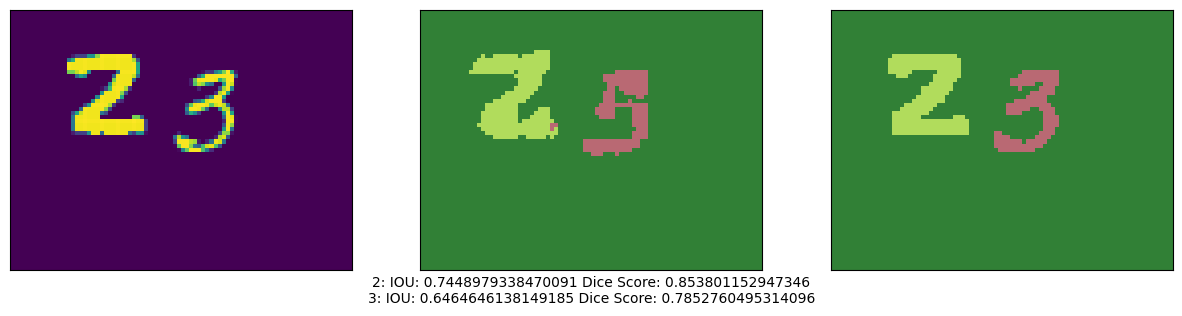

In [77]:
# place a number here between 0 to 191 to pick an image from the test set
integer_slider = 120

ds = test_dataset.unbatch()
ds = ds.batch(200)
images = []

y_true_segments = []
for image, annotation in ds.take(2):
  y_true_segments = annotation
  images = image


iou, dice_score = class_wise_metrics(np.argmax(y_true_segments[integer_slider], axis=2), results[integer_slider])
show_annotation_and_prediction(image[integer_slider], annotation[integer_slider], results[integer_slider], iou, dice_score)


### Compute IOU Score and Dice Score of your model

In [79]:
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(np.argmax(y_true_segments, axis=3), results)

average_iou = 0.0
for idx, (iou, dice_score) in enumerate(zip(cls_wise_iou[:-1], cls_wise_dice_score[:-1])):
  print("Digit {}: IOU: {} Dice Score: {}".format(idx, iou, dice_score))
  average_iou += iou

grade = average_iou * 10

print("\nGrade is " + str(grade))

#PASSING_GRADE = 60
#if (grade>PASSING_GRADE):
#  print("You passed!")
#else:
#  print("You failed. Please check your model and re-train")

Digit 0: IOU: 0.7499999990786241 Dice Score: 0.8571428565411423
Digit 1: IOU: 0.7512864472518969 Dice Score: 0.8579823688247105
Digit 2: IOU: 0.6614563468528958 Dice Score: 0.7962368052652311
Digit 3: IOU: 0.6437994716888433 Dice Score: 0.7833065806103494
Digit 4: IOU: 0.6240396096567533 Dice Score: 0.7685029428421962
Digit 5: IOU: 0.6313425210501863 Dice Score: 0.7740158953789249
Digit 6: IOU: 0.6624129919416424 Dice Score: 0.7969295176982061
Digit 7: IOU: 0.7113509287331284 Dice Score: 0.8313326235896272
Digit 8: IOU: 0.6289206293198047 Dice Score: 0.7721930927750922
Digit 9: IOU: 0.6431618226564092 Dice Score: 0.7828344278552491

Grade is 67.07770768230183


## Save the Model (Optional in Colab)

- save the model file in your Colab workspace.

In [ ]:
# Save the model you just trained
model.save("temp_model.h5")

Tensorflow releases minor and patch updates every few months ([sometimes quicker](https://pypi.org/project/tensorflow/#history)). Oftentimes, the code and syntax won't change but the newer versions will have a different model definition under the hood. The next cells will convert your newer model to one that the grader can read. You won't have to do this in your personal projects. This is just an extra step for grading.

In [ ]:
# Install packages for compatibility with the autograder

# NOTE: You can safely ignore errors about version incompatibility of
# Colab-bundled packages (e.g. xarray, pydantic, etc.)

!pip install tensorflow==2.8.0 --quiet
!pip install keras==2.8.0 --quiet

Wait for the cell above to complete. After that, **go to `Runtime > Restart Session` and wait for the kernel to reconnect.** This is necessary so you can reload Tensorflow with the version installed above. Run the next cell to check if you have the correct version. You will get an `AssertionError` if you didn't restart the session.

In [ ]:
import tensorflow as tf

# Check if you have the correct Tensorflow version
assert tf.__version__ == '2.8.0', f'You have TF{tf.__version__}. Please install the grader-compatible Tensorflow and select Runtime > Restart Session'

If you didn't get an error above, you can finally convert the model.

In [ ]:
# Load the model you saved earlier
model = tf.keras.models.load_model("temp_model.h5", compile=False)

# Save the model with the compatible TF version
model.save("final_model.h5")

Please look for `final_model.h5` in the File Explorer on the left and download it. Then go back to the Coursera classroom and upload it to the Lab item that points to the autograder of Week 3. Alternatively, you can also use the cell below to download the model.



In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("final_model.h5")